Домашнее задание по результатам 8 вебинара.  
  
	Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции   
 y=sin(x)/x-x/10  
   
При выполнении данного задания структура GAN остается той же, но Вам нужно:  
	Сгенерировать настоящие данные  
	Изменить архитектуру дискриминатора и генератора  
	Без графиков домашку не принимаю  
	(*Усложненное задание) Используя датасет MNIST из урока, построить модели генератора и дискриминатора в модели DCGAN как   описано в оригинальной статье. И обучите ее на данных MNIST. В качестве помощи, можете воспользоваться официальной статьей от   pytorch.   


Подключаем нужные модули и библиотеки

In [18]:
import os
import numpy as np
import pandas as pd
import math
import random

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

from sklearn.model_selection import train_test_split
########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

Определим нужное нам устройство:

In [19]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [20]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [21]:
num = 50
numbers = [i/100 for i in range(-5000, 5000)]
# numbers

In [22]:
x = np.array(numbers)

In [23]:
def f(x):    
    return (np.sin(x)/x)-(x/10)


In [24]:
y = [f(ii) for ii in x]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


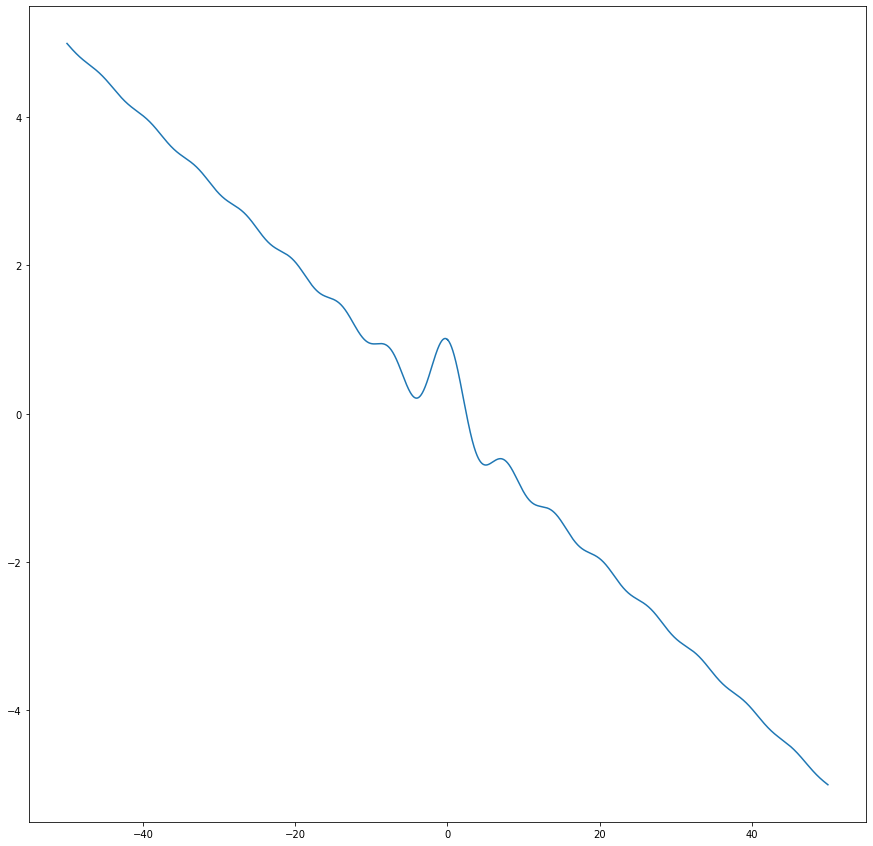

In [25]:
plt.figure(figsize=(15, 15))
plt.plot(x, y)

In [26]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.FloatTensor(data)
        if target is not None:
            self.target = torch.FloatTensor(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None

            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [27]:
img_size = 1 # размер картинки которую мы будет подавать в нейронные сети
batch_size = 16 # размер батча
img_shape = (img_size, img_size) # полный шейп нашей картинки


n_epochs = 10 # количество эпох
lr = 0.0002 # шаг обучения
b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 10 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [28]:
train_dataset = DataWrapper(x,target= y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        # 2

    def forward(self, z):
#         print(z.size())
        img = self.model(z)
#         print(f'размер после прохождения генератора: {z.size()}')
        img = img.view(img.size(0), *img_shape)
#         print(f'размер после преобразования: {z.size()}')
        return img

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
#             nn.Linear(int(np.prod(img_shape)), 512),
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
#             nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
#         print(img.size(), img_flat.size())
        validity = self.model(img_flat)

        return validity

In [31]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [32]:
d_loss_history = []
g_loss_history = []

[Epoch 9/10] [Batch 600/625] [D loss: 0.002325] [G loss: 0.004649]


<Figure size 432x288 with 0 Axes>

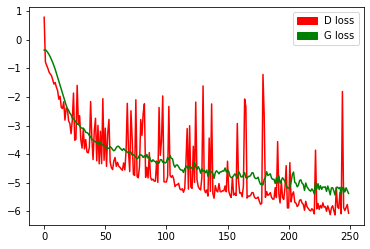

In [33]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        
##################### Лnnейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, fake)
#         torch.mean(torch.log(prob_artist0) + torch.log(1. - prob_artist1))
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward(retain_graph=False)
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward(retain_graph=False)
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
#                 sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_loader), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

# DCGAN

In [1]:
import os
import numpy as np
import pandas as pd
import math
import random

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

from sklearn.model_selection import train_test_split
########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms  
# astransforms import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [4]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [5]:
# Корневой каталог для набора данных 
dataroot= "data/mnist"

# Количество рабочих для загрузчика данных
workers = 2

# Размер пакета во время обучения
batch_size = 14

# Пространственный размер обучающих изображений. Все изображения будут изменены до этого
# размера с помощью transformer.
img_size = 28

# Количество каналов в обучающих изображениях. Для цветных изображений это 3
channels = 1

# Размер скрытого вектора z (т. Е. Размер входного сигнала генератора)
nz = 100

# Размер карт объектов в генераторе
ngf = 28

# Размер карт объектов в дискриминаторе
ndf = 28

# Количество эпох обучения
num_epochs = 5

# Скорость обучения для оптимизаторов
lr = 0.0002

# Beta1 hyperparam для оптимизаторов Adam
beta1 = 0.5

# Количество доступных графических процессоров. Используйте 0 для режима процессора.
ngpu = 0

ks = 4 #kernel size

# полный шейп нашей картинки
img_shape = (channels, img_size, img_size) 

In [24]:
# real_data = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         "./data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=batch_size,
#     shuffle=True,
#     drop_last=True,
# )

In [26]:
import torch.utils.data as data_utils
ds = datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    )
indices = torch.arange(10000)
tr_10k = data_utils.Subset(ds, indices)

In [27]:
real_data = torch.utils.data.DataLoader(
    tr_10k,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

In [28]:
len(real_data)

714

img_shape = (1, 28, 28)
lable_shape = torch.Size([])
img_shape after squeeze = (28, 28)


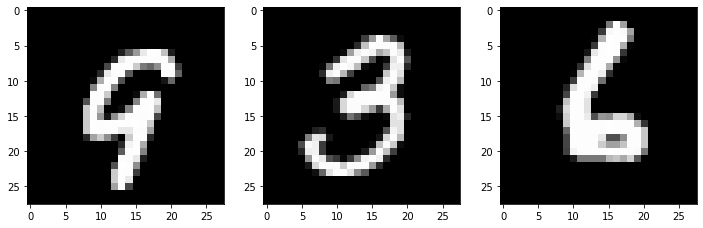

In [29]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'lable_shape = {labels[0].size()}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [30]:
# nz = 100

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
#             nn.BatchNorm2d(nz),
            nn.ConvTranspose2d( nz, ngf * 7, ks, 3, 1, bias=False),
            nn.BatchNorm2d(ngf * 7),
            nn.ReLU(True),
#             nn.ConvTranspose2d( ngf * 14, ngf * 7, ks, 3, 1, bias=False),
#             nn.BatchNorm2d(ngf * 7),
#             nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(196, 98, ks, 3, 1, bias=False),
            nn.BatchNorm2d(98),
            nn.ReLU(True),
            nn.ConvTranspose2d( 98, 49, ks, 3, 3, bias=False),
            nn.BatchNorm2d(49),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 49, ngf, ks, 3, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, channels, ks, 1, 1, bias=False),
#             print(1),
            nn.Tanh()
        )

    def forward(self, z):

        img = self.model(z)
        print(f"выход с генератора: {z.size()}")

        return img


In [31]:
gen = Generator()
print(gen)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 196, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(196, 98, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (4): BatchNorm2d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(98, 49, kernel_size=(4, 4), stride=(3, 3), padding=(3, 3), bias=False)
    (7): BatchNorm2d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(49, 28, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (10): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Ta

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(channels, ndf, 1, 1, 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, ks, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, ks, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, ks, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, ks, 1, 0, bias=False),
            nn.Sigmoid()
        )
  

    def forward(self, img):
        validity = self.model(img)
        return validity

In [33]:
dis = Discriminator()
print(dis)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(112, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(224, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [34]:
n_epochs = 5 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

# latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [35]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize BCELoss function
adversarial_loss = torch.nn.BCELoss()
# adversarial_loss = torch.nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(img_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))

In [36]:
d_loss_history = []
g_loss_history = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/5] [Batch 694/714] [D loss: 0.008362] [G loss: 7.227169]


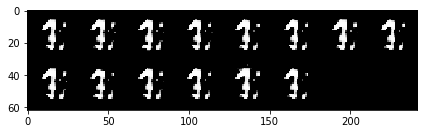

<Figure size 432x288 with 0 Axes>

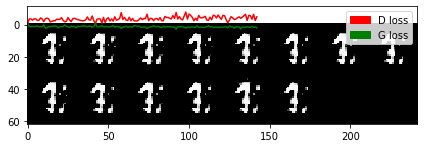

выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генератора: torch.Size([14, 100, 1, 1])
valid = torch.Size([14, 1, 1, 1])
выход с генерато

In [37]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        
##################### Лnnейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1,1,1).fill_(1.0).to(device)
#         valid = torch.FloatTensor(1)
        fake = torch.FloatTensor(batch_size, 1,1,1).fill_(0.0).to(device)
#         fake = torch.FloatTensor(0)

        real_imgs = imgs.type(torch.FloatTensor).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
#         z = torch.FloatTensor(np.random.normal(0, 1, ((img_size* img_size* channels), batch_size)))
#         z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, nz))).to(device)
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        
        # Генерируем даные Генератором на основе шума
#         print(z.size())
#         print(type(z))
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
#         print(f"validity.size() = {validity.view(1,-1).size()}")
        print(f"valid = {validity.size()}")
#         valid = generator(valid)
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            